> This is a rework of my task during Computer Vision class in 2022.

> Goal(s):
- to implement non-maximum suppression and hysteresis thresholding both on canny edge detection and LOG, then compare.

# Import Library

In [1]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

from scipy import ndimage

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Image Preparation

In [3]:
url = 'https://www.birdsofmurrieta.com/uploads/7/5/8/4/75844173/fluffy-yellow-duckling-alamy_orig.jpg'
url_2 = 'https://thumbs.dreamstime.com/b/cartoon-black-white-cow-vector-milking-spots-standing-four-legs-smiling-112330624.jpg'

In [4]:
def generate_img(url):
  req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
  img_data = urllib.request.urlopen(req).read()
  img_array = np.frombuffer(img_data, np.uint8)
  img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
  return img

In [5]:
def show_img(img, title, cmap=None):
  plt.imshow(img, cmap=cmap)
  plt.title(title)
  plt.axis('off')

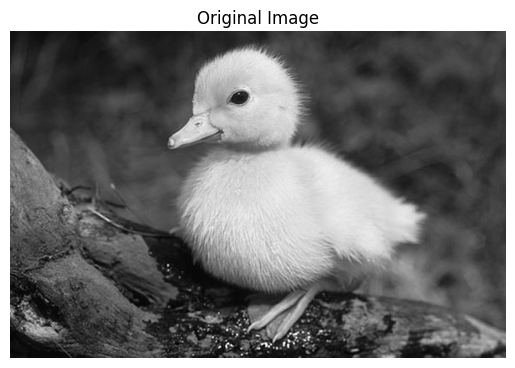

In [6]:
img = cv2.cvtColor(generate_img(url), cv2.COLOR_BGR2GRAY)
show_img(img, 'Original Image', 'gray')

In [7]:
img = img.astype(np.float64)

# Canny Edge Detector

## Apply Gaussian Filter

> Edge Detection is sensitive to image noise. Therefore, the first step to do is to remove noise from the image.

> Gaussian Filter used to remove image noise is based on this formula:

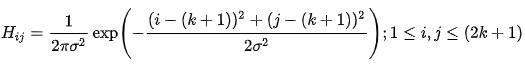

In [8]:
def gaussian_kernel(k_size, sigma):
  x, y = np.mgrid[-k_size : k_size + 1, -k_size : k_size + 1]
  g =  (1 / (2 * np.pi * (sigma ** 2))) * np.exp(-1 * ((x ** 2 + y ** 2) / (2 * (sigma ** 2))))
  return g

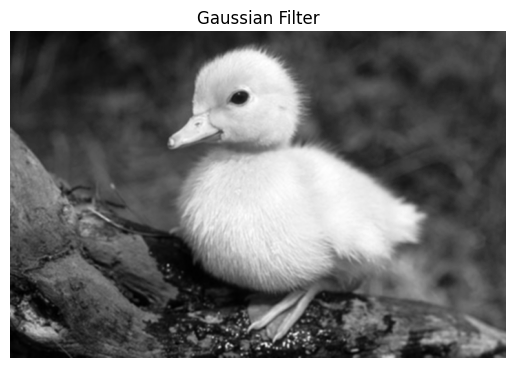

In [9]:
img_gaussian = ndimage.convolve(img, gaussian_kernel(5, 1))
show_img(img_gaussian, 'Gaussian Filter', 'gray')

## Compute `f_x` and `f_y`

> Sobel Filter used to highlight intensity change from both direction (horizontal x and vertical y) is based on this formula:

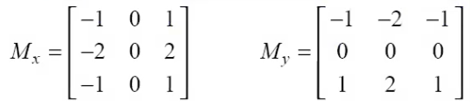

In [10]:
def sobel_filters(img):
  Mx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
  My = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], np.float32)

  fx = ndimage.filters.convolve(img, Mx)
  fy = ndimage.filters.convolve(img, My)
  return fx, fy

In [11]:
fx, fy = sobel_filters(img_gaussian)

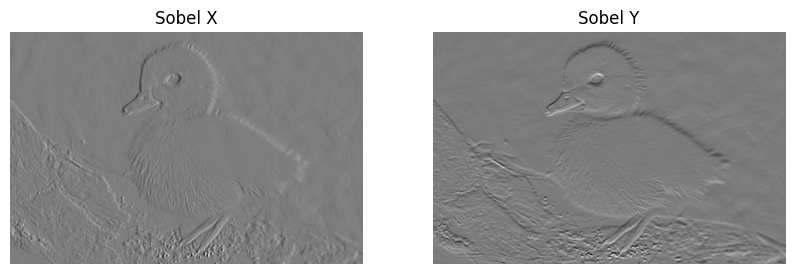

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
show_img(fx, 'Sobel X', 'gray')
plt.subplot(1, 2, 2)
show_img(fy, 'Sobel Y', 'gray')

## Compute the Gradient Magnitude

> Gradient Magnitude and Gradient Direction based on:

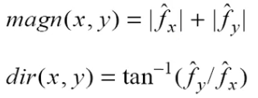

In [13]:
def calc_gradient(fx, fy):
  magn = np.sqrt(fx ** 2 + fy ** 2)
  magn = magn / magn.max() * 255
  dir = np.arctan2(fy, fx)
  return dir, magn

In [14]:
dir, magn = calc_gradient(fx, fy)

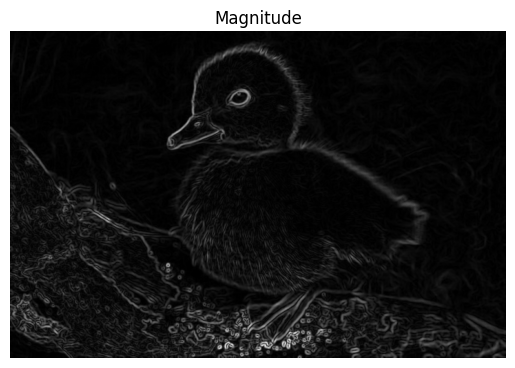

In [15]:
show_img(magn.astype(int), 'Magnitude', 'gray')

## Apply Non-Maximum Suppresion

> Non Maximum Suppression is done after edge points (local maxima) are found. Therefore, Non Maximum Suppression traces along the edges found (compare it to its neighbors) and suppresses any pixel value that is not at the maximum suppression in the image. Hence, it results tidier and thinner line in the output image.

> Non-Maxima Suppression based on:

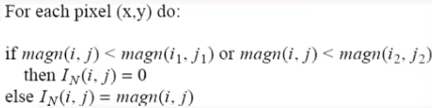

![Untitled.png](https://i0.wp.com/theailearner.com/wp-content/uploads/2019/05/Grad_direc-2.png?w=713&ssl=1)

In [16]:
def non_max_suppression(img, D):
  temp = np.zeros(img.shape, dtype=np.int32)
  dir = D * 180. / np.pi
  dir[dir < 0] += 180

  for i in range(1, img.shape[0] - 1):
    for j in range(1, img.shape[1] - 1):
      q = r = 255
      if (0 <= dir[i,j] < 22.5) or (157.5 <= dir[i,j] <= 180):
          q = img[i, j+1]
          r = img[i, j-1]
      elif (22.5 <= dir[i,j] < 67.5):
          q = img[i+1, j-1]
          r = img[i-1, j+1]
      elif (67.5 <= dir[i,j] < 112.5):
          q = img[i+1, j]
          r = img[i-1, j]
      elif (112.5 <= dir[i,j] < 157.5):
          q = img[i-1, j-1]
          r = img[i+1, j+1]
      
      if img[i, j] >= q and img[i, j] >= r:
        temp[i, j] = img[i, j]
      else:
        temp[i, j] = 0
  return temp

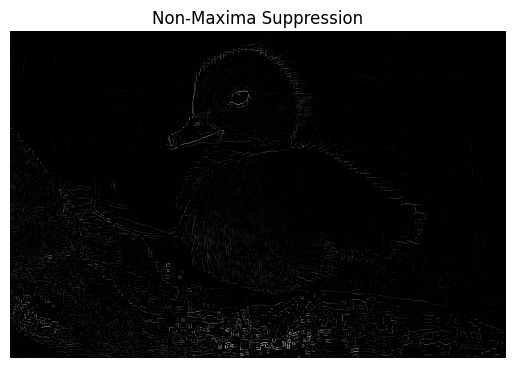

In [17]:
img_NMS = non_max_suppression(magn, dir)
show_img(img_NMS, 'Non-Maxima Suppression', 'gray')

## Apply Double Threshold

> Double Threshold is used to emphasize the difference between strong pixel and weak pixel. Those pixels which are not in strong pixel or weak pixel categories are considered not an edge.

In [18]:
weakThresh = 80
strongThresh = 255

In [19]:
def double_thresh(img, lowThresh=40, highThresh=80):
  temp = np.zeros(img.shape, dtype=np.int32)
  strong_i, strong_j = np.where(img >= highThresh)
  weak_i, weak_j = np.where((img >= lowThresh) & (img < highThresh))

  temp[strong_i, strong_j] = strongThresh
  temp[weak_i, weak_j] = weakThresh

  return temp

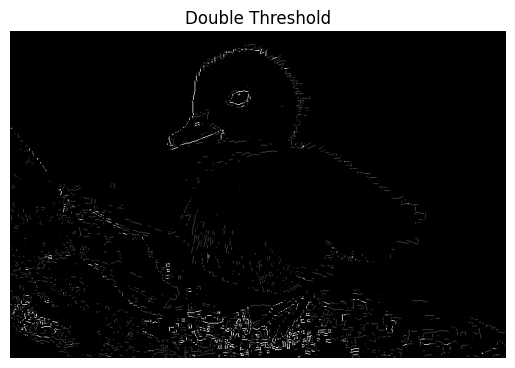

In [20]:
img_DThresh = double_thresh(img_NMS)
show_img(img_DThresh, 'Double Threshold', 'gray')

> Hence, the edges now are more clearer.

## Apply Hysteresis Thresholding / Edge Linking

> Hysteresis Thresholding or Edge Linking gets rid the remaining local maxima created by noise from the output from the previous steps by emphasizing those pixels which were considered as weak pixels to strong pixels only if it passes some terms. It usually has two thresholds, a low and a high threshold, so that it can rejects noisy maxima but still can accepts the true maxima. It compares each pixel with its neighbors, if there is any of its neighbor is a strong pixel, then the current pixel will also be considered as strong pixel.

In [21]:
def isStrong(img, i, j):
  if ((img[i+1, j-1] == strongThresh) or (img[i+1, j] == strongThresh) or (img[i+1, j+1] == strongThresh)):
    return True
  elif ((img[i, j-1] == strongThresh) or (img[i, j+1] == strongThresh)):
    return True
  elif ((img[i-1, j-1] == strongThresh) or (img[i-1, j] == strongThresh) or (img[i-1, j+1] == strongThresh)):
    return True
  else:
    return False

In [22]:
def hysteresis(img):
  temp = img.copy()
  for i in range(1, img.shape[0] - 1):
    for j in range(1, img.shape[1] - 1):
      if (img[i, j] == weakThresh):
        if (isStrong(img, i, j)):
          temp[i, j] = strongThresh
        else:
          temp[i, j] = 0

  return temp

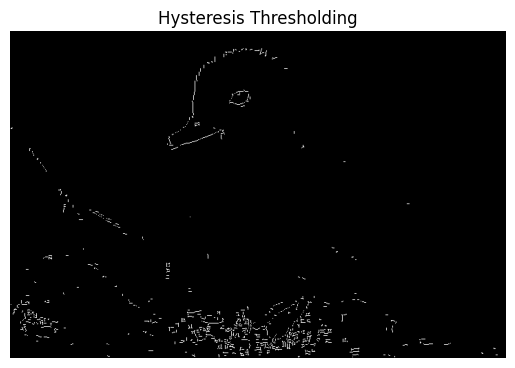

In [23]:
img_hysteresis = hysteresis(img_DThresh)
show_img(img_hysteresis, 'Hysteresis Thresholding', 'gray')

# LOG

## Apply Gaussian Filter

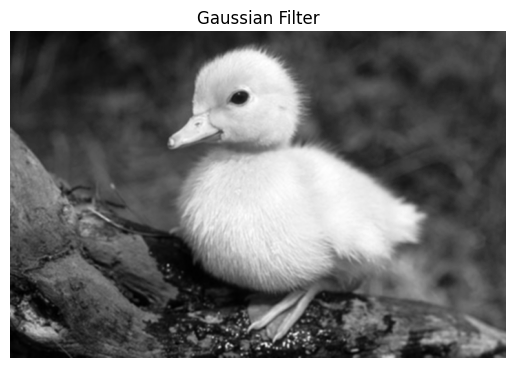

In [24]:
img_gaussian = ndimage.convolve(img, gaussian_kernel(5, 1))
show_img(img_gaussian, 'Gaussian Filter', 'gray')

## Apply Laplacian of Gaussian

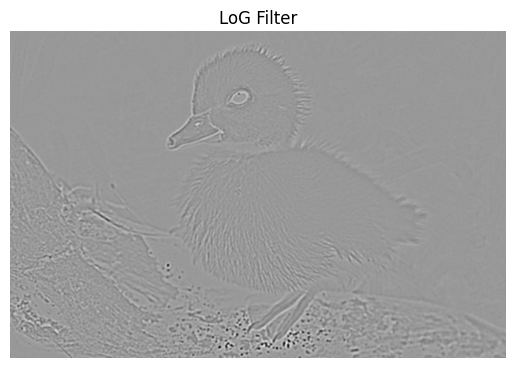

In [25]:
img_LOG = ndimage.gaussian_laplace(img_gaussian, sigma=1)
show_img(img_LOG, 'LoG Filter', 'gray')

## Zero Crossing

In [26]:
def zero_cross_detect(img):
  img_zc = np.zeros(img.shape)
  for i in range(1, img.shape[0] - 1):
    for j in range(1, img.shape[1] - 1):
      neg_c = 0
      pos_c = 0
      neighbour = [img[i+1, j-1], img[i+1, j], img[i+1, j+1],
                   img[i, j-1], img[i, j+1],
                   img[i-1, j-1], img[i-1, j], img[i-1, j+1]]
      d = max(neighbour)
      e = min(neighbour)
      for h in neighbour:
        if h > 0:
          pos_c += 1
        elif h < 0:
          neg_c += 1
      z_c = ((neg_c > 0) and (pos_c > 0))
      if z_c:
        if img[i,j] > 0:
          img_zc[i, j] = img[i,j] + np.abs(e)
        elif img[i,j] < 0:
          img_zc[i, j] = np.abs(img[i,j]) + d
  return img_zc

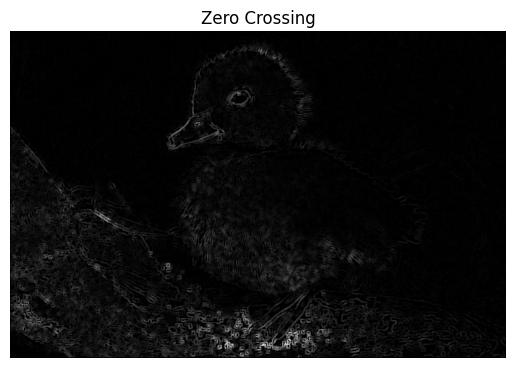

In [27]:
img_ZC = zero_cross_detect(img_LOG)
show_img(img_ZC, 'Zero Crossing', 'gray')

# Result

> Both Canny Edge Detector and Laplacian of Gaussian use Gaussian as its filtering steps, but different principles in other steps such as enhancement.

> Canny is considered optimum and is one of the most widely used Edge Detector in Computer Vision. First, Canny smooths the input image using Gaussian to reduces the effect of noise in the image. Then, it finds the image gradient before applying Non-Maxima Suppression which traces along the edges and suppresses any pixel value that is not at the maximum suppression in the image (it results tidier and thinner line in the output image). Lastly, applying Hysteresis Thresholding to removes the remaining local maxima created by noise from the output from the previous steps. It usually has two thresholds, a low and a high threshold.

> The Laplacian of Gaussian (LoG) first applies a Gaussian smoothing filter to the image to reduce noise. Then, the Laplacian operator is applied to detect edges by finding zero crossings, which indicate the edge points.

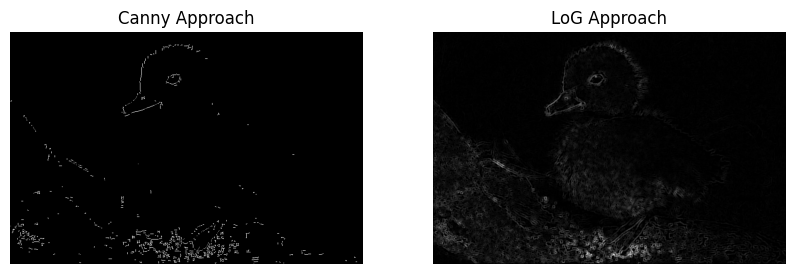

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
show_img(img_hysteresis, 'Canny Approach', 'gray')
plt.subplot(1, 2, 2)
show_img(img_ZC, 'LoG Approach', 'gray')

> The results indicate that while the Canny Edge Detector produces sharper edges, the Laplacian of Gaussian (LoG) provides a clearer outline, especially along most sides of the object.

# Other Example

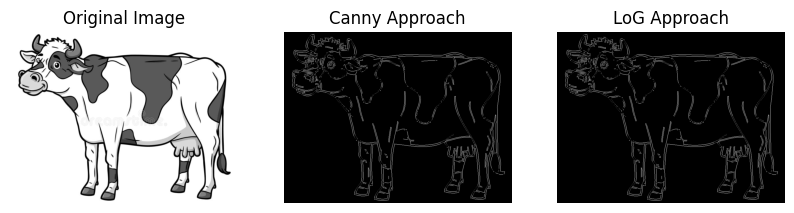

In [29]:
img_2 = cv2.cvtColor(generate_img(url_2), cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
show_img(img_2, 'Original Image', 'gray')

img_2 = img_2.astype(np.float64)
img_gaussian_2 = ndimage.convolve(img_2, gaussian_kernel(5, 1))
fx_2, fy_2 = sobel_filters(img_gaussian_2)
dir_2, magn_2 = calc_gradient(fx_2, fy_2)
img_NMS_2 = non_max_suppression(magn_2, dir_2)
img_DThresh_2 = double_thresh(img_NMS_2)
img_hysteresis_2 = hysteresis(img_DThresh_2)
plt.subplot(1, 3, 2)
show_img(img_hysteresis_2, 'Canny Approach', 'gray')

img_gaussian_2 = ndimage.convolve(img_2, gaussian_kernel(5, 1))
img_LOG_2 = ndimage.gaussian_laplace(img_gaussian_2, sigma=1)
img_ZC_2 = zero_cross_detect(img_LOG_2)
plt.subplot(1, 3, 3)
show_img(img_hysteresis_2, 'LoG Approach', 'gray')